In [13]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2

### Extracting data

In [14]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")


### utilities

In [19]:
def compute_iou(rois, boxes): 
    
    '''
        compute the pairwise IOU between rois and boxes and return a matrix of all iou score 
        where the coefficient (ith,jth) of the ith row, jth colomun is the iou score between the ith roi and jth boxe
    '''
    
    # convert all boxes and rois to corner coordinates
    rois = convert_to_corner(rois) 
    boxes = convert_to_corner(boxes)
    
    print("rois", rois)
    print("boxes", boxes)
    
    # getting minmum coordinates between all rois and each of the gt boxes
    
    xmin1, ymin1, xmax1, ymax1 = tf.split(value=rois, num_or_size_splits=4, axis=1) 
    xmin2, ymin2, xmax2, ymax2 = tf.split(value=boxes, num_or_size_splits=4, axis=1)
    
    x_min = tf.maximum(xmin1, tf.transpose(xmin2))
    y_min = tf.maximum(ymin1, tf.transpose(ymin2)) 
    
    x_max = tf.minimum(xmax1, tf.transpose(xmax2)) 
    y_max = tf.minimum(ymax1, tf.transpose(ymax2))
    
    width = tf.maximum(0.0, x_max - x_min)
    height = tf.maximum(0.0, y_max - y_min) 
    
    intersection = width * height
#     print("intersection : ", intersection) 
#     print()
    
    # computing the union (let's not forget to remove the intersection)
    roi_union = (xmax1 - xmin1) * (ymax1 - ymin1)
    boxes_union = (xmax2 - xmin2) * (ymax2 - ymin2)
    
#     print("roi union", roi_union) 
#     print("boxes_union", boxes_union) 
    
#     print("after expanding roi", tf.expand_dims(roi_union, 1))
#     print("after expanding boxes", tf.expand_dims(boxes_union, 0))
    
#     print("")
    full_union = tf.add(roi_union , tf.transpose(boxes_union)) # union with intersection
    proper_union = full_union - intersection
#     print("complete union", full_union)
    
    iou = intersection / proper_union
    
    return iou
    

In [15]:
class ROI: 
    
    '''
        class responsible for generating ROI using Selective Search
        ROI's shapes : x, y, w, h
    '''
    
    
    def __init__(self, resize_width=96, resize_height=96): 
        self.height = resize_width 
        self.width = resize_height
        
    def generate_roi(self, image, roi_nb): 
        '''
            return roi_nb ROI for the image of shape : x, y, w, h
            Arguments: 
                image : the actual sample image 
                roi_nb : the number of roi to extract from the image
        '''
        
        # TODO `| RESIZE THE ROI !
        
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()[:roi_nb]
        
        return tf.cast(tf.stack([rects[:,0], rects[:,1], rects[:,2], rects[:,3]], axis=-1), dtype=tf.float32)

In [28]:
class LabelEncoder: 
    
    '''
        The raw labels, consisting of bounding boxes and class ids need to be transformed into targets for training. 
        This transformation consists of the following steps:
            - Assigning ground truth boxes to the ROI boxes
            - The ROI boxes that are not assigned any objects, are either assigned the background class or ignored depending on the IOU
            - Generating the classification and regression targets using ROI boxes
    
    '''
    
    def __init__(self): 
        roi = ROI()
        
    def _match_roi_boxes(self, rois, gt_boxes, match_iou=0.02, ignore_iou=0.01): 
        
        """
            Matches ground truth boxes to rois boxes based on the IOU matrix
            Returns  
                [0] : a (number_of_rois, 1) tensor of  arg max indexes (for each roi)
                [1] : a (number_or_rois, 1) tensor with values of 1 if the corresponding bbox is a positive sample and 0 if not
                [2] : a (number_or_rois, 1) tensor with values of 1 if the corresponding bbox is a background (neg) sample and 0 if not

        """
        
        iou_matrix = compute_iou(rois, gt_boxes)
        print("iou matrix") 
        print(iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        max_idx = tf.math.argmax(iou_matrix, axis=1)
        positives = tf.greater_equal(max_iou, match_iou) # truth 
        negatives = tf.less(max_iou, ignore_iou) # truth
        # rest is being ignored 
        ignore = tf.logical_not(tf.logical_or(positives, negatives))
        print("MAX INDEX : ")
        print(max_idx)
        print()
        return max_idx, tf.cast(positives, dtype=tf.float32), tf.cast(ignore, dtype=tf.float32)
    
    def _get_box_target(self, gt_boxes, matched_rois): 
        """
            Calculate the regression targets for the training pair (gt_box, matched_roi)
            the regressor is configured to learn scale-invariant transformation between two centers and log-scale transformation between widths and heights.
            An obvious benefit of applying such transformation is that all the bounding box correction functions, di(p) where i∈{x,y,w,h}, can take any value between [-∞, +∞].
            
            Arguments: 
                gt_boxes : a (m, 4) tensor with (x,y,w,h) coordinates
                matched_rois : a (m, 4) tensor with (x,y,w,h) coordinates
        """
        
        tx = (gt_boxes[:, 0] - matched_rois[:, 0]) / matched_rois[:, 2]
        ty = (gt_boxes[:, 1] - matched_rois[:, 1]) / matched_rois[:, 3]
        tw = tf.math.log(gt_boxes[:, 2] / matched_rois[:, 2])
        th = tf.math.log(gt_boxes[:, 3] / matched_rois[:, 3])
        
        return tf.concat([tx, ty, tw, th], axis=1) 

    def _encode_sample(self, image, gt_boxes, cls_idx, roi_nb): 
        """Creates box and classification targets for a single sample"""
        rois = ROI.generate_roi(image, roi_nb)
        matched_boxes, positive, negative = self._match_roi_boxes(rois, gt_boxes, match_iou=0.02, ignore_iou=0.01)
        # match bboxes for an image to its class
        matched_gt_to_cls = tf.gather(gtx_boxes, matched_boxes)
        # generate box targets for training 
        box_target = self._get_box_target(rois, matched_gt_to_cls)
        # match cls to 
        matched_gt_cls_ids = tf.gather(cls_ids, matched_boxes) # gather class ids 
        # change class ids to -1 when negative 
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        # change class ids to -2 ignored
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1) # (m, 1) instead of (m,)
        # first 4 columns represent the bbox, last column represent the target label
        label = tf.concat([box_target, cls_target], axis=-1)
        
        return label



In [17]:
def convert_to_xywh(boxes): 
    '''
        Convert boxes with corner coordinates to xywh coordinates
        
        Arguments: 
            boxes: Tensor of size (num_boxes,4) 
    '''
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3] - boxes[:, 1], boxes[:,2] - boxes[:,0]], axis=-1)


def scale_bbox(boxes, image_shape): 
    
    '''
        Scale boxes with format xywh
    '''
    
    y_scale = image_shape[0]
    x_scale = image_shape[1] 
    return tf.stack([boxes[:, 0] * x_scale, boxes[:, 1] * y_scale, boxes[:, 2] * x_scale, boxes[:,3] * y_scale], axis=-1)


def convert_to_corner(boxes): 
    
    
    '''
        concert a batch of (xmin, ymin, w, h) boxes to (xmin, ymin, xmax, ymax)
    '''
    
    return tf.stack([boxes[:,0], boxes[:,1], boxes[:,0] + boxes[:,2], boxes[:,1] + boxes[:,3]], axis=-1)

In [18]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

autotune = tf.data.experimental.AUTOTUNE
train_dataset

<PrefetchDataset shapes: {image: (None, None, 3), image/filename: (), image/id: (), objects: {area: (None,), bbox: (None, 4), id: (None,), is_crowd: (None,), label: (None,)}}, types: {image: tf.uint8, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int64, bbox: tf.float32, id: tf.int64, is_crowd: tf.bool, label: tf.int64}}>

### let's visualize some samples

matching rois to bbox 

rois tf.Tensor(
[[  0. 317. 127. 402.]
 [318. 226. 640. 245.]
 [459. 173. 496. 198.]
 [  0. 286.  28. 299.]], shape=(4, 4), dtype=float32)
boxes tf.Tensor(
[[ 86.17    251.24    215.95    455.77002]
 [331.44    234.27    570.32    371.66998]
 [236.62001 150.84    283.64    301.24   ]], shape=(3, 4), dtype=float32)
iou matrix
tf.Tensor(
[[0.10247176 0.         0.        ]
 [0.         0.07046173 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]], shape=(4, 3), dtype=float32)
MAX INDEX : 
tf.Tensor([0 1 0 0], shape=(4,), dtype=int64)


matched_indx tf.Tensor([0 1 0 0], shape=(4,), dtype=int64)
positives tf.Tensor([1. 1. 0. 0.], shape=(4,), dtype=float32)


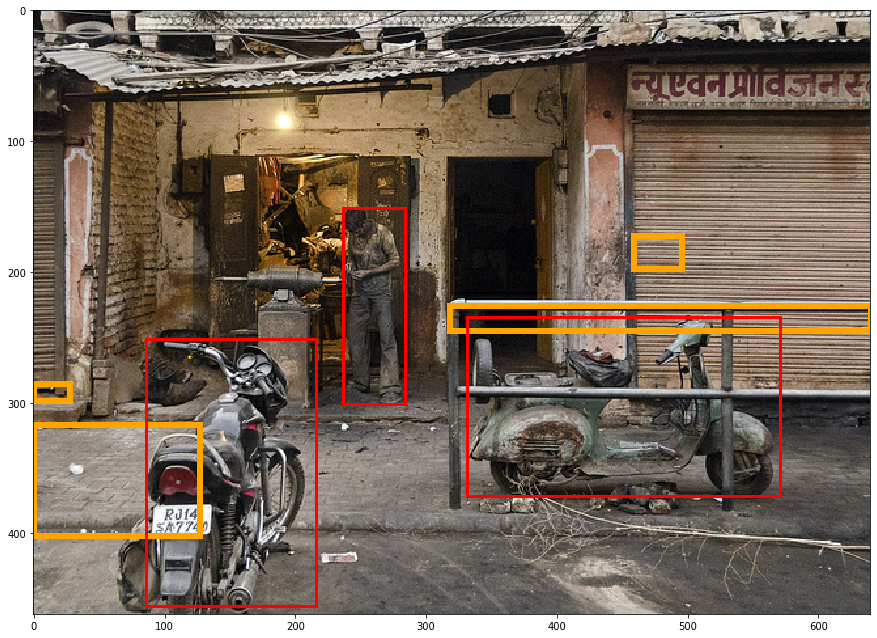

In [25]:
batch = train_dataset.take(1)

for idx, sample in enumerate(batch): 
#     print(sample["image/id"])
    image = sample["image"]
#     print("image shape ", image.shape)
    bboxs = sample["objects"]["bbox"]
#     print("bobxs shape ", bboxs.shape)
    labels = sample["objects"]["label"]
#     print("lables shape ,", labels.shape)
    plt.figure(figsize=(15,15)) 
    plt.imshow(image)
    ax = plt.gca()
    bboxs = convert_to_xywh(bboxs) 
    bboxs = scale_bbox(bboxs, (image.shape[0], image.shape[1]))
           
    rois = ROI().generate_roi(image.numpy(), 4)
    
    print("matching rois to bbox \n")
    matched_indx, positives, negatives = LabelEncoder()._match_roi_boxes(rois, bboxs)
    print() 
    print("matched_indx", matched_indx)
    print("positives", positives) 
    # generate roi 
    for roi in rois:
            
        rect2 = plt.Rectangle((roi[0], roi[1]), roi[2], roi[3],linewidth=6,edgecolor='orange',facecolor='none')
        ax.add_patch(rect2)

    for bbox_index, (bbox, label) in enumerate(zip(bboxs, labels)): 

        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    break
